In [1]:
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import numpy as np
from sklearn.metrics import f1_score
from statistics import mean

In [2]:
class Data(torch_data.Dataset):
    def __init__(self, X, y):
        super(Data, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return  self.X[idx], self.y[idx]

In [3]:
class DenseICNN(nn.Module):
    def __init__(self, input_dim, output_dim,  hidden_layer_sizes, activation='celu', dropout=0.3):
        super(DenseICNN, self).__init__()
        
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.droput = dropout
        self.activation = activation

        
        self.quadratic_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, output_features, bias=True),
                nn.Dropout(dropout))
            for output_features in hidden_layer_sizes])
        
        sizes = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.convex_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_features, output_features, bias=False),
                nn.Dropout(dropout))
            for (input_features, output_features) in sizes])
        
        self.final_layer = nn.Linear(hidden_layer_sizes[-1], output_dim, bias=False)
        
                        
    def forward(self, input):
        output = self.quadratic_layers[0](input)
        for quadratic_layer, convex_layer in zip(self.quadratic_layers[1:], self.convex_layers):
            output = convex_layer(output) + quadratic_layer(input)
            if self.activation == 'celu':
                output = torch.celu(output)
        return self.final_layer(output)
    
    def convexify(self):
        for layer in self.convex_layers:
            for sublayer in layer:
                if (isinstance(sublayer, nn.Linear)):
                    sublayer.weight.data.clamp_(0)

In [4]:
def train(epochs, ICNN, optimizer, data_loader, scheduler=None, verbose=True, save_dir=None):
    
    for epoch in range(1, epochs+1):
        f1 = []
        ICNN.train()
        for X, y in data_loader:
           
            y_out = ICNN(X)
            loss = criterion(y.unsqueeze(1), torch.sigmoid(y_out))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ICNN.convexify()
        
        
        ICNN.eval()
        for X, y in data_loader:
            
            y_out = ICNN(X)
            test_loss = criterion(y.unsqueeze(1), torch.sigmoid(y_out))
            predY_bin = (torch.sigmoid(y_out).detach().numpy() >= 0.55).astype(np.int)
            trueY_bin = np.expand_dims(y.detach().numpy(), axis=1)
            f1.append(f1_score(trueY_bin.T, predY_bin.T, average='micro', pos_label=None))
            
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,50)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), test_loss.item()))
            print('F1 score:', mean(f1))

In [5]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Moons dataset:
Epoch 50/300 || Loss:  Train 0.1279 | Validation 0.0687
F1 score: 0.8821820557839882
Epoch 100/300 || Loss:  Train 0.0617 | Validation 0.0478
F1 score: 0.9354706669988502
Epoch 150/300 || Loss:  Train 0.0268 | Validation 0.0107
F1 score: 0.9616232100453886
Epoch 200/300 || Loss:  Train 0.0189 | Validation 0.0274
F1 score: 0.9676387530041198
Epoch 250/300 || Loss:  Train 0.0568 | Validation 0.0149
F1 score: 0.9657003987474607
Epoch 300/300 || Loss:  Train 0.0438 | Validation 0.0211
F1 score: 0.9696775837636051

Circles dataset:
Epoch 50/300 || Loss:  Train 0.1583 | Validation 0.1702
F1 score: 0.9531013192708137
Epoch 100/300 || Loss:  Train 0.1232 | Validation 0.0917
F1 score: 0.9627478716606984
Epoch 150/300 || Loss:  Train 0.1033 | Validation 0.0732
F1 score: 0.9487402891662957
Epoch 200/300 || Loss:  Train 0.0646 | Validation 0.0737
F1 score: 0.9555303638144577
Epoch 250/300 || Loss:  Train 0.0737 | Validation 0.0576
F1 score: 0.9688546931363391
Epoch 300/300 || Loss: 

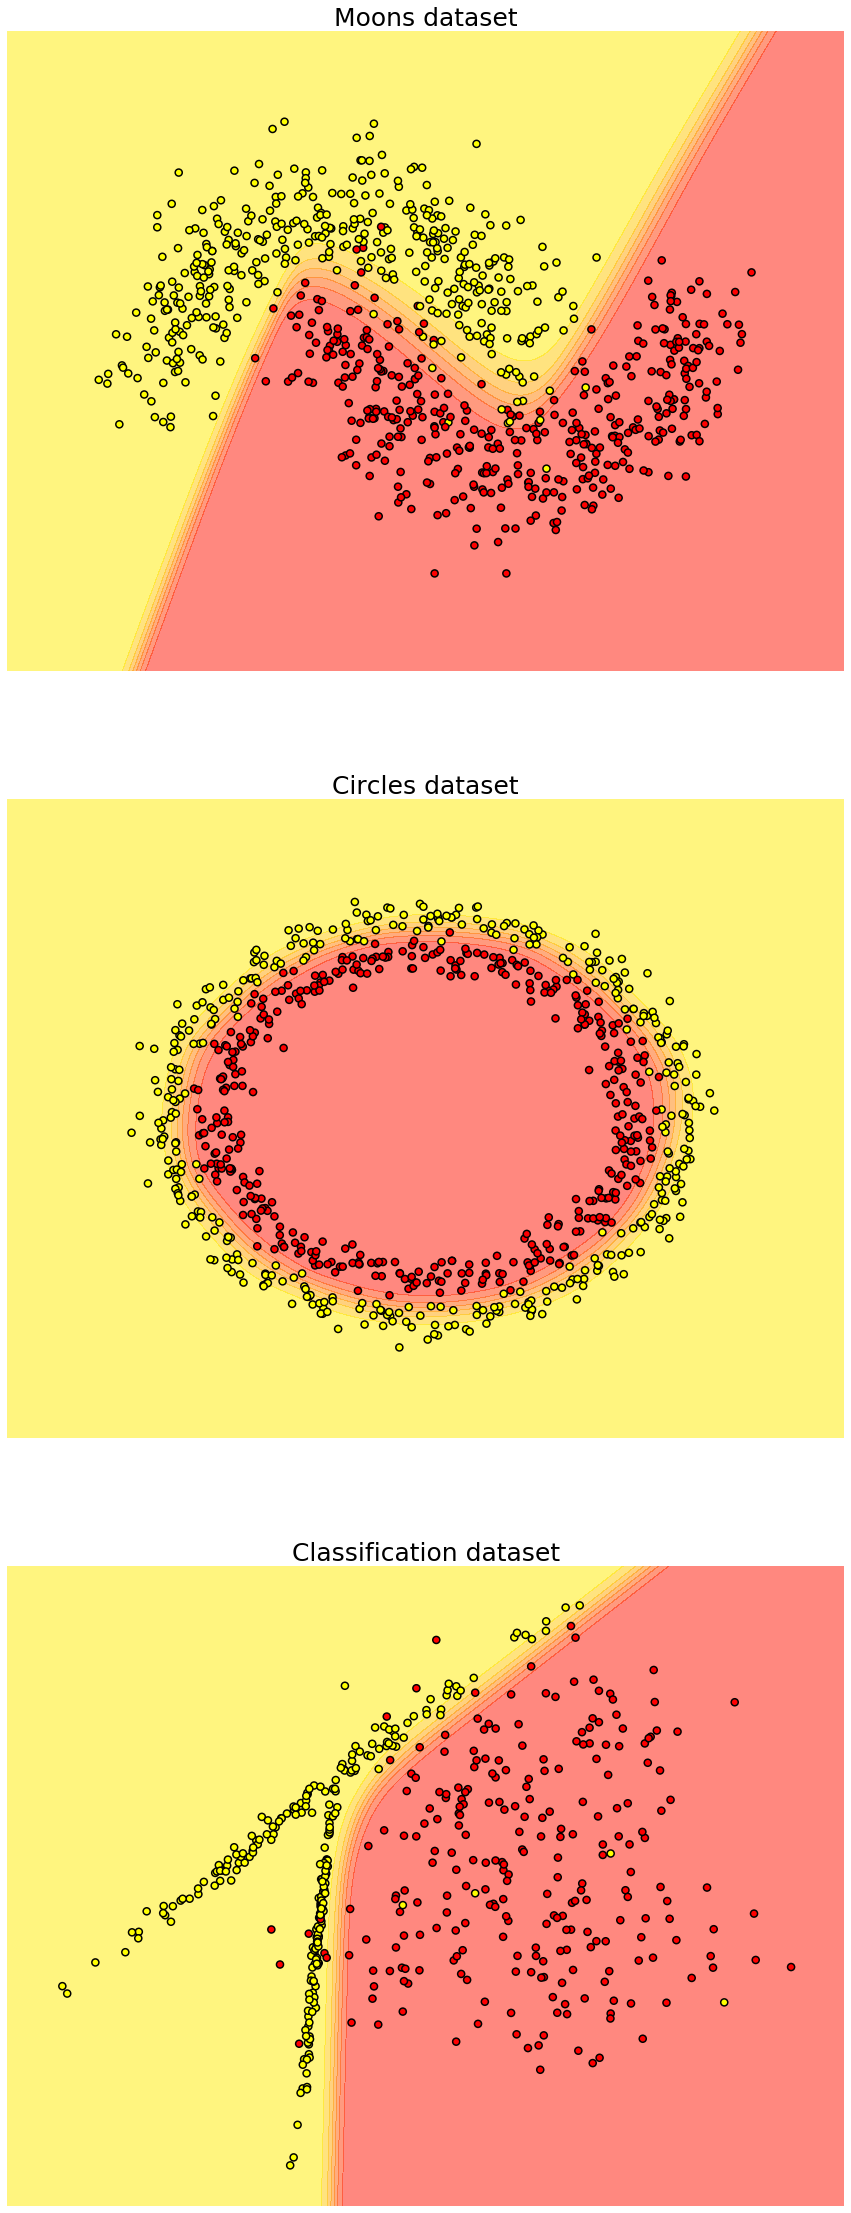

In [6]:
toy_examples = {'Moons': make_moons(n_samples=800, shuffle=True, noise=0.2, random_state=42),
                'Circles': make_circles(n_samples=800, shuffle=True, noise=0.05, random_state=42),
                'Classification': make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_classes=2, random_state=27)}
names = ['Moons', 'Circles', 'Classification']

fig, ax = plt.subplots(3, 1, figsize=(15,40))

output_dim = 1
hidden_layer_sizes=[60, 45]

for i in range(len(names)):
    print(names[i] + ' dataset:')
    
    x, y = toy_examples[names[i]]
    batch_size_train = x.shape[0]//10
    input_dim = x.shape[1]
    dataset = Data(x, y) 
    
    ICNN = DenseICNN(input_dim, output_dim,  hidden_layer_sizes, activation='celu') 
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ICNN.parameters(), lr=1e-3) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)
    data_loader = torch_data.DataLoader(dataset, batch_size=batch_size_train, shuffle=True) 
    train(300, ICNN, optimizer, data_loader)
    
    print()
    
    xx, yy = get_grid(x)
    pred = ICNN(Data(np.c_[xx.ravel(), yy.ravel()], np.c_[xx.ravel(), yy.ravel()])[:][0])
    zz = 1 - torch.sigmoid(pred).detach().numpy()
    
    ax[i].contourf(xx, yy, zz.reshape(xx.shape), alpha=0.5, cmap='autumn')
    ax[i].scatter(x[:,0], x[:,1], c=y, cmap = 'autumn_r',edgecolors='black', linewidth=1.5, s=50)
    ax[i].set_xlim(round(x[:,0].min(), 1) - 0.5, round(x[:,0].max(), 1) + 0.5)
    ax[i].set_ylim(round(x[:,1].min(), 1) - 0.5, round(x[:,1].max(), 1) + 0.5)
    ax[i].axis('off')
    ax[i].set_title(names[i] + ' dataset', fontsize=25)